# con1 modifications

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
sys.path.insert(1, 'libraries')
import rc
import sections as sect
import materials as mat
import utils

In [2]:
def plotStress(self,curve,title="",lbl="",xlim=(None,None),ylim=(None,None),plotting=True,legend=True):
    if plotting:
        fig,ax = utils.plotBase()
        ax.plot(curve['strain'],curve['stress'],'-', linewidth=2, markersize=5,label=lbl)
        if legend:
            ax.legend(loc='lower right')
        ax.set_title(title)
        ax.set_xlabel('Strain')
        ax.set_ylabel('Stress [MPa]')
        ax.set_xlim(xlim)
        ax.set_ylim(ylim)
        plt.show()
    return curve['strain'],curve['stress']

In [3]:
def alpha_plot(alphat,alphac,extra):
    if alphat==0: at='='
    elif alphat>0: at='>'
    else: at='<'
    if alphac==0: ac='='
    elif alphac>0: ac='>'
    else: ac='<'
    title='C50, alphac '+ac+' 0, alphat '+at+' 0'+extra
    return title

In [229]:
class stmdl2_KR:
    # this is con1 ADAPTIC model
    def __init__(self,ec0,muec1,strnc1,stresc1,et0,muet1,strnt1,pset,crks,alphac,alphat):#pseto,crkso,
        # This subroutine calculates the stress at a monitoring point for
        # material MODEL(2).

        # Establish the stress depending on the sign of the applied
        # strain relative to the initial plastic set and crack strain
        self.ec0=ec0 # Secant compressive stiffness
        self.muec1=muec1 # Compressive softening stiffness
        self.strnc1=strnc1 # strain at residual compressive strength 
        self.stresc1=stresc1 # residual compressive strength 
        self.et0=et0 # Tensile stiffness
        self.muet1=muet1 # Tensile softening stiffness
        self.strnt1=strnt1 # strain at peak tensile strength ?
        self.pseto=pseto # plastic strain in compression at the start of the step, 
                         # represents the intersection of the unloading branch with the strain axis
        self.crkso=crkso # plastic strain in tension at the start of the step
        self.pset=pseto
        self.crks=crkso
        self.alphac=alphac
        self.alphat=alphat

    def y_E1(self,x,E1,E0,x0,x1,y0,printing=True): 
        a=(E0-E1)/2/(x0-x1)
        b=E0-2*a*x0
        c=y0-a*x0**2-b*x0
        if printing: print('y(x) = {0}x**2+{1}x+{2}'.format(a,b,c))
        return (x-x0)**2*(E0-E1)/(2*(x0-x1))+E0*(x-x0)+y0

    def y_S(self,x,S,E0,x0,x1,y0,printing=True): 
        a=2*(E0-S)/2/(x0-x1)
        b=E0-2*a*x0
        c=y0-a*x0**2-b*x0
        if printing: print('y(x) = {0}x**2+{1}x+{2}'.format(a,b,c))
        return (x-x0)**2*(E0-S)/(x0-x1)+E0*(x-x0)+y0

    def y_prime_E1(self,x,E1,E0,x0,x1,y0,printing=True): 
        a=(x*(E0-E1)+x0*E1-x1*E0)/(x0-x1)
        b=(x**2*(E1-E0)-x0**2*(E0+E1)+2*x0*x1*E0)/(2*(x0-x1))+y0
        if printing: print('y\'(x) = {0}x+{1}'.format(a,b))
        return (a,b)

    def y_prime_S(self,x,S,E0,x0,x1,y0,printing=True): 
        a=(x*2*(E0-S)+x0*(2*S-E0)-x1*E0)/(x0-x1)
        b=(S*x**2-S*x0**2-x**2*E0+x0*x1*E0)/(x0-x1)+y0
        if printing: print('y\'(x) = {0}x+{1}'.format(a,b))
        return (a,b)
    
    def secant(self,S,x0,y0,printing=True): 
        a=S
        b=y0-a*x0
        if printing: print('secant: y(x) = {0}x+{1}'.format(a,b))
        return (a,b)

    def stress(self, strn,printing=False):
        self.strn=strn
        if(self.strn<=self.pseto):      # Compressive strain increment
            # NOTE: quad is the relative difference between the initial
            #       compressive tangent modulus and the secant modulus

            self.ec0t=(1+np.absolute(self.alphac))*self.ec0 # initial tangent modulus in compression

            if(self.alphac!=0): # implies quadratic initial compressive response 
                # if plastic response occured: ??
                self.strnc0=(self.stresc1-self.muec1*self.strnc1)/(self.ec0-self.muec1)
                
            # Obtain the stress assuming elastic conditions, and determine
            # the force from the limiting curve
            self.strese=self.ec0t*(self.strn-self.pseto) # elastic stress based on ec0t
            # this gives stress in intial compressive response if quad = 0

            if(self.alphac!=0 and self.strn>self.strnc0): # initial quadratic response
                # range: pseto>=strn>strnc0

                #quadratic formulation for stress:
                self.stresl=self.strn*(self.ec0t+(self.ec0-self.ec0t)*self.strn/self.strnc0)
                self.etan=self.ec0t+2*(self.ec0-self.ec0t)*self.strn/self.strnc0

            elif(self.alphac<0 and self.strn>self.strnc1): # softening branch
                # quadratic formulation for stress:
                if (self.strn<(self.strnc0+self.strnc1)/2):
                    self.stresl=self.stresc1-2*(self.strnc1-self.strn)**2*self.muec1/(self.strnc1-self.strnc0)
                    ##-2(x0-x)**2*S/(x0-x1), as the interval is irregular
                    compare=self.y_S(x=self.strn,S=self.muec1,E0=0,x1=(self.strnc0+self.strnc1)/2,x0=self.strnc1,y0=self.stresc1,printing=printing)
                    if np.absolute((compare-self.stresl)/compare)>0.01: print('ERROR, compression part2, y_S={}, hand={}'.format(self.stresl,compare))

                    compare=self.y_prime_S(x=self.strn,S=self.muec1,E0=0,x1=(self.strnc0+self.strnc1)/2,x0=self.strnc1,y0=self.stresc1,printing=printing)[0]
                    self.etan=4*self.muec1*(self.strnc1-self.strn)/(self.strnc1-self.strnc0)
                    # 4*S*(x0-x)/(x0-x1), as the interval is irregular
                    if np.absolute((compare-self.etan)/compare)>0.01: print('ERROR, y_prime_S={}, hand={}'.format(self.etan,compare))
                else:
                    self.stresl=self.strnc0*self.ec0+2*(self.strn-self.strnc0)**2*self.muec1/(self.strnc1-self.strnc0)
                     # y0-2*S*(x-x0)**2/(x0-x1)+x2*(x-x0, as the interval is irregular
                    compare=self.y_S(x=self.strn,S=self.muec1,E0=0,x1=(self.strnc0+self.strnc1)/2,x0=self.strnc0,y0=self.strnc0*self.ec0,printing=printing)
                    if np.absolute((compare-self.stresl)/compare)>0.01: print('ERROR, compression part1, y_S={}, hand={}'.format(self.stresl,compare))

                    compare=self.y_prime_S(x=self.strn,S=self.muec1,E0=0,x1=(self.strnc0+self.strnc1)/2,x0=self.strnc0,y0=self.strnc0*self.ec0,printing=printing)[0]
                    self.etan=4*self.muec1*(self.strnc0-self.strn)/(self.strnc0-self.strnc1)
                    #4*S*(x0-x)/(x0-x1), as the interval is irregular
                    if np.absolute((compare-self.etan)/compare)>0.01: print('ERROR, y_prime_S={}, hand={}'.format(self.etan,compare))
                
            elif(self.strn>self.strnc1): # softening branch
                self.stresl=self.stresc1+self.muec1*(self.strn-self.strnc1)
                self.etan=self.muec1

            else: # residual compressive strength

                self.stresl=self.stresc1
                self.etan=0.0

            # Establish the stress and the plastic set

            if(self.strese>self.stresl):

                self.stres=self.strese
                self.pset=self.pseto
                self.etan=self.ec0t

            else:

                self.stres=self.stresl
                self.pset=self.strn-self.stresl/self.ec0t

            self.crks=self.crkso

        elif(self.et0==0.0 or self.strn<self.crkso+self.pseto):   # Cracked zone

            self.stres=0.0
            self.pset=self.pseto
            self.crks=self.crkso
            self.etan=0

        else:   # Tensile strain increment

            # Obtain the stress assuming elastic conditions, and
            # determine the force from the limiting curve
            
            self.strest1=self.et0*self.strnt1
            self.strnt2=self.strnt1-self.strest1/self.muet1
            if(self.alphat<0): # implies initial quadratic tensile response 
                self.muet1t=-self.alphat*self.muet1+self.muet1    
            elif(self.alphat>0): # implies total quadratic tensile response 
                self.et0t=self.alphat*self.et0+self.et0
            
            self.strese=self.et0*(self.strn-(self.pseto+self.crkso))

            self.stresl=self.muet1*(self.strn-(self.pseto+self.strnt1))+self.et0*self.strnt1  # my modification

            # Establish the stress and crack
            
            if(self.stresl<=0.0): # ultimate tensile strain is exceeded
                self.stres=0.0
                self.etan=0.0
                self.crks=self.strn-self.pseto-self.stresl/self.et0

            elif((self.strn-self.pseto)<self.strnt1): # initial quadratic tensile response
                self.crks=self.crkso
                if(alphat>0 and self.crkso==0):
                    self.stres=(self.strn-self.pseto)*(self.et0t+(self.et0-self.et0t)*(self.strn-self.pseto)/self.strnt1)
                    #x*(E0+(S-E0)*x/x1)
                    compare=self.y_S(x=(self.strn-self.pseto),S=self.et0,E0=self.et0t,x0=0,x1=self.strnt1,y0=0,printing=printing)
                    if np.absolute((compare-self.stres)/compare)>0.01: print('ERROR, initial response, y_S={}, hand={}'.format(self.stres,compare))

                    compare=self.y_prime_S(x=(self.strn-self.pseto),S=self.et0,E0=self.et0t,x0=0,x1=self.strnt1,y0=0,printing=printing)[0]
                    self.etan=(self.strnt1*self.et0t-(self.strn-self.pseto)*2*(self.et0t-self.et0))/self.strnt1
                    #(x1*E0-x*2*(E0-S))/x1
                    if np.absolute((compare-self.etan)/compare)>0.01: print('ERROR, initial response, y_prime_S={}, hand={}'.format(self.etan,compare))

                else:
                    self.stres=self.strese
                    self.etan=self.et0
                    
            elif(self.stresl>0): # tensile softening
                self.etanl=self.muet1
                if (alphat<0  and (self.strn-self.pseto)<self.strnt2 ): # quadratic formulation for stress
                    compare=self.y_S(x=(self.strn-self.pseto),S=self.muet1,E0=self.muet1t,x0=self.strnt1,x1=self.strnt2,y0=self.strest1,printing=printing)
                    self.stresl=self.strest1+((self.strn-self.pseto)-self.strnt1)**2*(self.muet1t-self.muet1)/(self.strnt1-self.strnt2)+self.muet1t*((self.strn-self.pseto)-self.strnt1)
                    if np.absolute((compare-self.stresl)/compare)>0.01: print('ERROR, tensile softening, y_S={}, hand={}'.format(self.stresl,compare))
                    
                    compare=self.y_prime_S(x=(self.strn-self.pseto),S=self.muet1,E0=self.muet1t,x0=self.strnt1,x1=self.strnt2,y0=self.strest1,printing=printing)[0]
                    self.etanl=((self.strn-self.pseto)*2*(self.muet1t-self.muet1)+self.strnt1*(2*self.muet1-self.muet1t)-self.strnt2*self.muet1t)/(self.strnt1-self.strnt2)
                    if np.absolute((compare-self.etanl)/compare)>0.01: print('ERROR, tensile softening, y_prime_S={}, hand={}'.format(self.etanl,compare))
                elif (alphat>0 and (self.strn-self.pseto)<self.strnt2): # 4th order polynomial formulation for stress
                    if ((self.strn-self.pseto)>(self.strnt1+self.strnt2)/2):
                        self.stresl=-2*(self.strnt2-(self.strn-self.pseto))**2*self.muet1/(self.strnt2-self.strnt1)
                        ##-2(x0-x)**2*S/(x0-x1), as the interval is irregular
                        compare=self.y_S(x=(self.strn-self.pseto),S=self.muet1,E0=0,x1=(self.strnt1+self.strnt2)/2,x0=self.strnt2,y0=0,printing=printing)
                        if np.absolute((compare-self.stresl)/compare)>0.01: print('ERROR, tensile softening, y_S={}, hand={}'.format(self.stresl,compare))
                        
                        compare=self.y_prime_S(x=(self.strn-self.pseto),S=self.muet1,E0=0,x1=(self.strnt1+self.strnt2)/2,x0=self.strnt2,y0=0,printing=printing)[0]
                        self.etanl=4*self.muet1*(self.strnt2-(self.strn-self.pseto))/(self.strnt2-self.strnt1)
                        # 4*S*(x0-x)/(x0-x1), as the interval is irregular
                        if np.absolute((compare-self.etanl)/compare)>0.01: print('ERROR, tensile softening, y_prime_S={}, hand={}'.format(self.etanl,compare))
                    else:
                        self.stresl=self.strest1-2*self.muet1*((self.strn-self.pseto)-self.strnt1)**2/(self.strnt1-self.strnt2)
                        # y0-2*S*(x-x0)**2/(x0-x1)+x2*(x-x0, as the interval is irregular
                        compare=self.y_S(x=(self.strn-self.pseto),S=self.muet1,E0=0,x1=(self.strnt1+self.strnt2)/2,x0=self.strnt1,y0=self.strest1,printing=printing)
                        if np.absolute((compare-self.stresl)/compare)>0.01: print('ERROR, tensile softening, y_S={}, hand={}'.format(self.stresl,compare))
                        
                        compare=self.y_prime_S(x=(self.strn-self.pseto),S=self.muet1,E0=0,x1=(self.strnt1+self.strnt2)/2,x0=self.strnt1,y0=self.strest1,printing=printing)[0]
                        self.etanl=4*self.muet1*(self.strnt1-(self.strn-self.pseto))/(self.strnt1-self.strnt2)
                        #4*S*(x0-x)/(x0-x1), as the interval is irregular
                        if np.absolute((compare-self.etanl)/compare)>0.01: print('ERROR, tensile softening, y_prime_S={}, hand={}'.format(self.etanl,compare))
                # Establish the stress and crack for tensile softening
                if(self.strese<self.stresl):
                    self.stres=self.strese
                    self.etan=self.et0
                    self.crks=self.crkso
                else:
                    self.stres=self.stresl
                    self.etan=self.etanl
                    self.crks=self.strn-self.pseto-self.stresl/self.et0
                #print('if self.stresl>0: x={}, strese={}, stresl={}'.format(self.strn,self.strese,self.stresl))
            else:print('ERROR')
            self.pset=self.pseto

        return self.stres

    def plot(self,title='stmdl2',step_size=0.001,legend=True,ranges='',printing=False):
        if ranges=='':ranges=[-np.absolute(self.strnc1),np.absolute(self.strnt1)]
        strain=np.arange(ranges[0],ranges[1],step_size)
        stress=np.array([self.stress(i) for i in strain])
        strain=strain.reshape(len(strain),1)
        stress=stress.reshape(len(stress),1)
        self.df=pd.DataFrame(np.hstack((stress,strain)),columns=['stress','strain'])
        #self.np=plotStress(self,self.df,lbl="stmdl2",plotting='True',title=title,legend=legend)
        #self.np=np.array(self.np)
        fig,ax = utils.plotBase()
        ax.plot(self.df['strain'],self.df['stress'],'-', linewidth=2, markersize=5,label='')
        if printing:
            ax.plot(self.strnt1+self.pseto,self.strest1,'or')
            ax.plot(self.strnt2+self.pseto,0,'or')
            print('point 1 = [{},{}]'.format(self.strnt1+self.pseto,self.strest1))
            print('point 2 = [{},{}]'.format(self.strnt2+self.pseto,0))
            if alphat<0 and False:
                # peak tensile strength point
                x=(self.strn-self.pseto)
                self.stress(x,printing=True)
                A=self.y_prime_E1(x=x,E1=0,E0=self.muet1t,x0=self.strnt1,x1=self.strnt2,y0=self.strest1,printing=True)
                ax.plot(strain,[A[0]*i+A[1] for i in strain],0,)

point 1 = [-0.00038,4.632000000000001]
point 2 = [0.0005282352941176473,0]
point 1 = [-0.00038,4.632000000000001]
point 2 = [0.0005282352941176473,0]
point 1 = [-0.00038,4.632000000000001]
point 2 = [0.0005282352941176473,0]


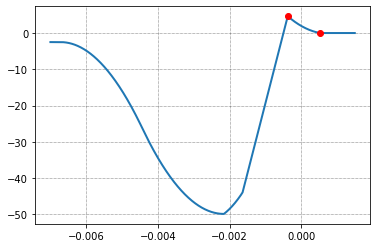

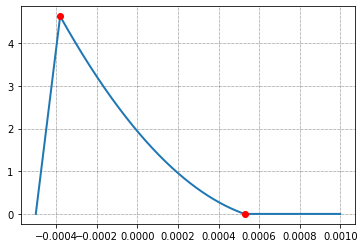

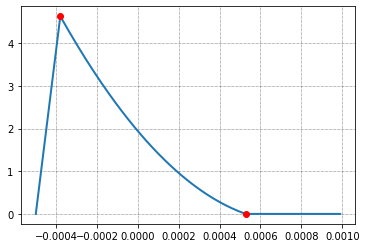

In [232]:
concr = mat.con1('C50', 50, 250, epsilon_t2 = 0.001, fc2_factor = 0.05, characteristic = True,plotting=False,)

ec0=concr.Ec1
muec1=concr.Ec2
et0=concr.Et1
muet1=concr.Et2

strnt1=concr.epsilon_1t
#strnc0=-concr.epsilon_1c
strnc1=-concr.epsilon_2c

stresc1=-concr.fc2
#strnt2=concr.epsilon_2t

pseto=-0.0005
crkso=0.0001
crkso=0#0.0003

quad=concr.alpha
alphac=-concr.alpha
alphat=-concr.alpha
etan=concr.Ec0

extra=''
    
#con1=stmdl2(ec0,muec1,strnc1,stresc1,et0,muet1,strnt1,pseto,crkso,quad)#pset,crks,
con1=stmdl2_KR(ec0,muec1,strnc1,stresc1,et0,muet1,strnt1,pseto,crkso,alphac,alphat)#pset,crks,
con1.plot(title=alpha_plot(alphat,alphac,extra),step_size=0.00001,legend=True,ranges=[-.007,.0015],printing=True)
con1.plot(title=alpha_plot(alphat,alphac,extra),step_size=0.000001,legend=True,ranges=[-0.0005,0.001],printing=True)

crkso=0
con1=stmdl2_KR(ec0,muec1,strnc1,stresc1,et0,muet1,strnt1,pseto,crkso,alphac,alphat)#pset,crks,
con1.plot(title=alpha_plot(alphat,alphac,extra),step_size=0.00001,legend=True,ranges=[-0.0005,0.001],printing=True)
#[-0.0005,0.001]  [-.007,.0015]

In [209]:
pseto=0#-0.0005#-0.0005
crkso=0.0003
quad=concr.alpha
etan=concr.Ec0
con1=stmdl2_KR(ec0,muec1,strnc1,stresc1,et0,muet1,strnt1,pseto,crkso,alphac,alphat)#pset,crks,
strn=0.00038
con1.stress(strn)
#con1.strest0
#self=con1 #self.strest0+((self.strn-self.pseto)-self.strnt1)*(self.muet1t+(self.muet1-self.muet1t)*((self.strn-self.pseto)-self.strnt1)/(self.strnt2-self.strnt1))

x=0.00038, strese=3.088000000000002, stresl=3.3060000000000005


3.088000000000002

In [7]:
print('ec0=',concr.Ec1)
print('muec1=',concr.Ec2)
print('et0=',concr.Et1)
print('muet1=',concr.Et2)
print('strnt1=',concr.epsilon_1t)
print('strnc0=',concr.epsilon_1c)
print('strnc1=',concr.epsilon_2c)
print('stresc1=',concr.fc2)
print('strnt2=',concr.epsilon_1t)
print('pseto=',concr.epsilon_2c)
print('crkso=',concr.epsilon_1t)
print('pset=',concr.epsilon_2c)
print('crks=',concr.epsilon_1t)
print('quad=',concr.alpha)
print('etan=',concr.Ec0)

ec0= 23100
muec1= -10400
et0= 38600
muet1= -5100
strnt1= 0.00012
strnc0= 0.00216
strnc1= 0.00672
stresc1= 2.5
strnt2= 0.00012
pseto= 0.00672
crkso= 0.00012
pset= 0.00672
crks= 0.00012
quad= 0.67
etan= 38600


In [8]:
con1.stress(-0.002)
print('stres',con1.stres)
#print('strnc0',con1.strnc0)
print('stresc1',con1.stresc1)
print('stresl',con1.stresl)
print('epsilon_1c',concr.epsilon_1c)

stres -48.50397513400011
stresc1 -2.5
stresl -48.50397513400011
epsilon_1c 0.00216


In [130]:
class stmdl2_KR_SS_20201119_plots:
    # this is con1 ADAPTIC model
    def __init__(self,ec0,muec1,strnc1,stresc1,et0,muet1,strnt1,pset,crks,alphac,alphat):#pseto,crkso,
        # This subroutine calculates the stress at a monitoring point for
        # material MODEL(2).

        # Establish the stress depending on the sign of the applied
        # strain relative to the initial plastic set and crack strain
        self.ec0=ec0 # Secant compressive stiffness
        self.muec1=muec1 # Compressive softening stiffness
        self.strnc1=strnc1 # strain at residual compressive strength 
        self.stresc1=stresc1 # residual compressive strength 
        self.et0=et0 # Tensile stiffness
        self.muet1=muet1 # Tensile softening stiffness
        self.strnt1=strnt1 # strain at peak tensile strength ?
        self.pseto=pseto # plastic strain in compression at the start of the step, 
                         # represents the intersection of the unloading branch with the strain axis
        self.crkso=crkso # plastic strain in tension at the start of the step
        self.pset=pseto
        self.crks=crkso
        self.alphac=alphac
        self.alphat=alphat

    def y_E1(self,x,E1,E0,x0,x1,y0,printing=True): 
        a=(E0-E1)/2/(x0-x1)
        b=E0-2*a*x0
        c=y0-a*x0**2-b*x0
        if printing: print('y(x) = {0}x**2+{1}x+{2}'.format(a,b,c))
        return (x-x0)**2*(E0-E1)/(2*(x0-x1))+E0*(x-x0)+y0

    def y_S(self,x,S,E0,x0,x1,y0,printing=True): 
        a=2*(E0-S)/2/(x0-x1)
        b=E0-2*a*x0
        c=y0-a*x0**2-b*x0
        if printing: print('y(x) = {0}x**2+{1}x+{2}'.format(a,b,c))
        return (x-x0)**2*(E0-S)/(x0-x1)+E0*(x-x0)+y0

    def y_prime_E1(self,x,E1,E0,x0,x1,y0,printing=True): 
        a=(x*(E0-E1)+x0*E1-x1*E0)/(x0-x1)
        b=(x**2*(E1-E0)-x0**2*(E0+E1)+2*x0*x1*E0)/(2*(x0-x1))+y0
        if printing: print('y\'(x) = {0}x+{1}'.format(a,b))
        return (a,b)

    def y_prime_S(self,x,S,E0,x0,x1,y0,printing=True): 
        a=(x*2*(E0-S)+x0*(2*S-E0)-x1*E0)/(x0-x1)
        b=(S*x**2-S*x0**2-x**2*E0+x0*x1*E0)/(x0-x1)+y0
        if printing: print('y\'(x) = {0}x+{1}'.format(a,b))
        return (a,b)
    
    def secant(self,S,x0,y0,printing=True): 
        a=S
        b=y0-a*x0
        if printing: print('secant: y(x) = {0}x+{1}'.format(a,b))
        return (a,b)

    def stress(self, strn,printing=False):
        self.strn=strn
        if(self.strn<=self.pseto):      # Compressive strain increment
            # NOTE: quad is the relative difference between the initial
            #       compressive tangent modulus and the secant modulus

            self.ec0t=(1+np.absolute(self.alphac))*self.ec0 # initial tangent modulus in compression

            if(self.alphac!=0): # implies quadratic initial compressive response 
                # if plastic response occured: ??
                self.strnc0=(self.stresc1-self.muec1*self.strnc1)/(self.ec0-self.muec1)
                
            # Obtain the stress assuming elastic conditions, and determine
            # the force from the limiting curve
            self.strese=self.ec0t*(self.strn-self.pseto) # elastic stress based on ec0t
            # this gives stress in intial compressive response if quad = 0

            if(self.alphac!=0 and self.strn>self.strnc0): # initial quadratic response
                # range: pseto>=strn>strnc0

                #quadratic formulation for stress:
                self.stresl=self.strn*(self.ec0t+(self.ec0-self.ec0t)*self.strn/self.strnc0)
                self.etan=self.ec0t+2*(self.ec0-self.ec0t)*self.strn/self.strnc0

            elif(self.alphac<0 and self.strn>self.strnc1): # softening branch
                # quadratic formulation for stress:
                if (self.strn<(self.strnc0+self.strnc1)/2):
                    self.stresl=self.stresc1-2*(self.strnc1-self.strn)**2*self.muec1/(self.strnc1-self.strnc0)
                    ##-2(x0-x)**2*S/(x0-x1), as the interval is irregular
                    compare=self.y_S(x=self.strn,S=self.muec1,E0=0,x1=(self.strnc0+self.strnc1)/2,x0=self.strnc1,y0=self.stresc1,printing=printing)
                    if np.absolute((compare-self.stresl)/compare)>0.01: print('ERROR, compression part2, y_S={}, hand={}'.format(self.stresl,compare))

                    compare=self.y_prime_S(x=self.strn,S=self.muec1,E0=0,x1=(self.strnc0+self.strnc1)/2,x0=self.strnc1,y0=self.stresc1,printing=printing)[0]
                    self.etan=4*self.muec1*(self.strnc1-self.strn)/(self.strnc1-self.strnc0)
                    # 4*S*(x0-x)/(x0-x1), as the interval is irregular
                    if np.absolute((compare-self.etan)/compare)>0.01: print('ERROR, y_prime_S={}, hand={}'.format(self.etan,compare))
                else:
                    self.stresl=self.strnc0*self.ec0+2*(self.strn-self.strnc0)**2*self.muec1/(self.strnc1-self.strnc0)
                     # y0-2*S*(x-x0)**2/(x0-x1)+x2*(x-x0, as the interval is irregular
                    compare=self.y_S(x=self.strn,S=self.muec1,E0=0,x1=(self.strnc0+self.strnc1)/2,x0=self.strnc0,y0=self.strnc0*self.ec0,printing=printing)
                    if np.absolute((compare-self.stresl)/compare)>0.01: print('ERROR, compression part1, y_S={}, hand={}'.format(self.stresl,compare))

                    compare=self.y_prime_S(x=self.strn,S=self.muec1,E0=0,x1=(self.strnc0+self.strnc1)/2,x0=self.strnc0,y0=self.strnc0*self.ec0,printing=printing)[0]
                    self.etan=4*self.muec1*(self.strnc0-self.strn)/(self.strnc0-self.strnc1)
                    #4*S*(x0-x)/(x0-x1), as the interval is irregular
                    if np.absolute((compare-self.etan)/compare)>0.01: print('ERROR, y_prime_S={}, hand={}'.format(self.etan,compare))
                
            elif(self.strn>self.strnc1): # softening branch
                self.stresl=self.stresc1+self.muec1*(self.strn-self.strnc1)
                self.etan=self.muec1

            else: # residual compressive strength

                self.stresl=self.stresc1
                self.etan=0.0

            # Establish the stress and the plastic set

            if(self.strese>self.stresl):

                self.stres=self.strese
                self.pset=self.pseto
                self.etan=self.ec0t

            else:

                self.stres=self.stresl
                self.pset=self.strn-self.stresl/self.ec0t

            self.crks=self.crkso

        elif(self.et0==0.0 or self.strn<self.crkso+self.pseto):   # Cracked zone

            self.stres=0.0
            self.pset=self.pseto
            self.crks=self.crkso
            self.etan=0

        else:   # Tensile strain increment

            # Obtain the stress assuming elastic conditions, and
            # determine the force from the limiting curve
            if(self.alphat!=0):
                self.strest1=self.et0*self.strnt1
                self.strnt2=self.strnt1-self.strest1/self.muet1
                if(self.alphat<0): # implies initial quadratic tensile response 
                    self.muet1t=-self.alphat*self.muet1+self.muet1
                elif(self.alphat>0): # implies total quadratic tensile response 
                    self.et0t=self.alphat*self.et0+self.et0
            
            self.strese=self.et0*(self.strn-(self.pseto+self.crkso))

            self.stresl=self.muet1*(self.strn-(self.pseto+self.strnt1))+self.et0*self.strnt1  # my modification

            if(self.stresl>0.0):
                
                self.etan=self.muet1

            else: # 'if ultimate tensile strain is exceeded'
                self.stresl=0.0
                self.etan=0.0

            # Establish the stress and the plastic set

            if(self.strese<self.stresl): # initial tensile response
            #if (self.strn-(self.pseto+self.crkso))<self.strnt1:
                if (alphat>0): # quadratic response
                    self.stresq=(self.strn-self.pseto)*(self.et0t+(self.et0-self.et0t)*(self.strn-self.pseto)/self.strnt1)
                    #x*(E0+(S-E0)*x/x1)
                    compare=self.y_S(x=(self.strn-self.pseto),S=self.et0,E0=self.et0t,x0=0,x1=self.strnt1,y0=0,printing=printing)
                    if np.absolute((compare-self.stresq)/compare)>0.01: print('ERROR, y_S={}, hand={}'.format(self.stresq,compare))
                    
                    self.strese=self.et0t*(self.strn-(self.pseto+self.crkso))
                    if (self.stresq<self.strese): # quadratic response
                        self.stres=self.stresq
                        compare=self.y_prime_S(x=(self.strn-self.pseto),S=self.et0,E0=self.et0t,x0=0,x1=self.strnt1,y0=0,printing=printing)[0]
                        self.etan=(self.strnt1*self.et0t-(self.strn-self.pseto)*2*(self.et0t-self.et0))/self.strnt1
                        #(x1*E0-x*2*(E0-S))/x1
                        if np.absolute((compare-self.etan)/compare)>0.01: print('ERROR, y_prime_S={}, hand={}'.format(self.etan,compare))
                    else: # linear response
                        self.stres=self.strese
                        self.etan=self.et0t
                else:
                    self.stres=self.strese
                    self.etan=self.et0
                self.crks=self.crkso
            else: # tensile softening
                if (alphat<0  and (self.strn-self.pseto)<self.strnt2 ): # quadratic formulation for stress
                    compare=self.y_S(x=(self.strn-self.pseto),S=self.muet1,E0=self.muet1t,x0=self.strnt1,x1=self.strnt2,y0=self.strest1,printing=printing)
                    self.stresl=self.strest1+((self.strn-self.pseto)-self.strnt1)**2*(self.muet1t-self.muet1)/(self.strnt1-self.strnt2)+self.muet1t*((self.strn-self.pseto)-self.strnt1)
                    if np.absolute((compare-self.stresl)/compare)>0.01: print('ERROR, y_S={}, hand={}'.format(self.stresl,compare))
                    
                    compare=self.y_prime_S(x=(self.strn-self.pseto),S=self.muet1,E0=self.muet1t,x0=self.strnt1,x1=self.strnt2,y0=self.strest1,printing=printing)[0]
                    self.etan=((self.strn-self.pseto)*2*(self.muet1t-self.muet1)+self.strnt1*(2*self.muet1-self.muet1t)-self.strnt2*self.muet1t)/(self.strnt1-self.strnt2)
                    if np.absolute((compare-self.etan)/compare)>0.01: print('ERROR, y_prime_S={}, hand={}'.format(self.etan,compare))
                elif (alphat>0 and (self.strn-self.pseto)<self.strnt2): # quadratic formulation for stress
                    if ((self.strn-self.pseto)>(self.strnt1+self.strnt2)/2):
                        self.stresl=-2*(self.strnt2-(self.strn-self.pseto))**2*self.muet1/(self.strnt2-self.strnt1)
                        ##-2(x0-x)**2*S/(x0-x1), as the interval is irregular
                        compare=self.y_S(x=(self.strn-self.pseto),S=self.muet1,E0=0,x1=(self.strnt1+self.strnt2)/2,x0=self.strnt2,y0=0,printing=printing)
                        if np.absolute((compare-self.stresl)/compare)>0.01: print('ERROR, y_S={}, hand={}'.format(self.stresl,compare))
                        
                        compare=self.y_prime_S(x=(self.strn-self.pseto),S=self.muet1,E0=0,x1=(self.strnt1+self.strnt2)/2,x0=self.strnt2,y0=0,printing=printing)[0]
                        self.etan=4*self.muet1*(self.strnt2-(self.strn-self.pseto))/(self.strnt2-self.strnt1)
                        # 4*S*(x0-x)/(x0-x1), as the interval is irregular
                        if np.absolute((compare-self.etan)/compare)>0.01: print('ERROR, y_prime_S={}, hand={}'.format(self.etan,compare))
                    else:
                        self.stresl=self.strest1-2*self.muet1*((self.strn-self.pseto)-self.strnt1)**2/(self.strnt1-self.strnt2)
                        # y0-2*S*(x-x0)**2/(x0-x1)+x2*(x-x0, as the interval is irregular
                        compare=self.y_S(x=(self.strn-self.pseto),S=self.muet1,E0=0,x1=(self.strnt1+self.strnt2)/2,x0=self.strnt1,y0=self.strest1,printing=printing)
                        if np.absolute((compare-self.stresl)/compare)>0.01: print('ERROR, y_S={}, hand={}'.format(self.stresl,compare))
                        
                        compare=self.y_prime_S(x=(self.strn-self.pseto),S=self.muet1,E0=0,x1=(self.strnt1+self.strnt2)/2,x0=self.strnt1,y0=self.strest1,printing=printing)[0]
                        self.etan=4*self.muet1*(self.strnt1-(self.strn-self.pseto))/(self.strnt1-self.strnt2)
                        #4*S*(x0-x)/(x0-x1), as the interval is irregular
                        if np.absolute((compare-self.etan)/compare)>0.01: print('ERROR, y_prime_S={}, hand={}'.format(self.etan,compare))
                self.stres=self.stresl
                self.crks=self.strn-self.pseto-self.stresl/self.et0

        self.pset=self.pseto

        return self.stres

    def plot(self,title='stmdl2',step_size=0.001,legend=True,ranges=''):
        if ranges=='':ranges=[-np.absolute(self.strnc1),np.absolute(self.strnt1)]
        strain=np.arange(ranges[0],ranges[1],step_size)
        stress=np.array([self.stress(i) for i in strain])
        strain=strain.reshape(len(strain),1)
        stress=stress.reshape(len(stress),1)
        self.df=pd.DataFrame(np.hstack((stress,strain)),columns=['stress','strain'])
        #self.np=plotStress(self,self.df,lbl="stmdl2",plotting='True',title=title,legend=legend)
        #self.np=np.array(self.np)
        fig,ax = utils.plotBase()
        ax.plot(self.df['strain'],self.df['stress'],'-', linewidth=2, markersize=5,label='')
        ax.plot(self.strnt1+self.pseto,self.strest1,'or')
        ax.plot(self.strnt2+self.pseto,0,'or')
        print('point 1 = [{},{}]'.format(self.strnt1+self.pseto,self.strest1))
        print('point 2 = [{},{}]'.format(self.strnt2+self.pseto,0))
        if alphat<0 and True:
            # peak tensile strength point
            x=(self.strn-self.pseto)
            self.stress(x,printing=True)
            A=self.y_prime_E1(x=x,E1=0,E0=self.muet1t,x0=self.strnt1,x1=self.strnt2,y0=self.strest1,printing=True)
            ax.plot(strain,[A[0]*i+A[1] for i in strain],0,)

point 1 = [-0.00038,4.632000000000001]
point 2 = [0.0005282352941176473,0]


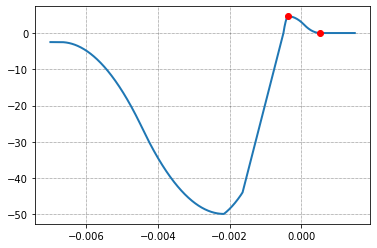

In [131]:
# nice plots
quad=concr.alpha
alphac=-concr.alpha
alphat=concr.alpha
con1=stmdl2_KR_SS_20201119_plots(ec0,muec1,strnc1,stresc1,et0,muet1,strnt1,pseto,crkso,alphac,alphat)#pset,crks,
con1.plot(title=alpha_plot(alphat,alphac,extra),step_size=0.00001,legend=True,ranges=[-.007,.0015])

In [72]:
class stmdl2_KR_SS_20201117:
    # this is con1 ADAPTIC model
    def __init__(self,ec0,muec1,strnc1,stresc1,et0,muet1,strnt1,pset,crks,alphac,alphat):#pseto,crkso,
        # This subroutine calculates the stress at a monitoring point for
        # material MODEL(2).

        # Establish the stress depending on the sign of the applied
        # strain relative to the initial plastic set and crack strain
        self.ec0=ec0 # Secant compressive stiffness
        self.muec1=muec1 # Compressive softening stiffness
        self.strnc1=strnc1 # strain at residual compressive strength 
        self.stresc1=stresc1 # residual compressive strength 
        self.et0=et0 # Tensile stiffness
        self.muet1=muet1 # Tensile softening stiffness
        self.strnt1=strnt1 # strain at peak tensile strength ?
        self.pseto=pseto # plastic strain in compression at the start of the step, 
                         # represents the intersection of the unloading branch with the strain axis
        self.crkso=crkso # plastic strain in tension at the start of the step
        self.pset=pseto
        self.crks=crkso
        self.alphac=alphac
        self.alphat=alphat
        
    def stress(self, strn):
        self.strn=strn
        if(self.strn<=self.pseto):      # Compressive strain increment
            # NOTE: quad is the relative difference between the initial
            #       compressive tangent modulus and the secant modulus

            self.ec0t=(1+np.absolute(self.alphac))*self.ec0 # initial tangent modulus in compression

            if(self.alphac!=0): # implies quadratic initial compressive response 
                # if plastic response occured: ??
                self.strnc0=(self.stresc1-self.muec1*self.strnc1)/(self.ec0-self.muec1)
                
            # Obtain the stress assuming elastic conditions, and determine
            # the force from the limiting curve
            self.strese=self.ec0t*(self.strn-self.pseto) # elastic stress based on ec0t
            # this gives stress in intial compressive response if quad = 0

            if(self.alphac!=0 and self.strn>self.strnc0): # initial quadratic response
                # range: pseto>=strn>strnc0

                #quadratic formulation for stress:
                self.stresl=self.strn*(self.ec0t+(self.ec0-self.ec0t)*self.strn/self.strnc0)
                self.etan=self.ec0t+2*(self.ec0-self.ec0t)*self.strn/self.strnc0

            elif(self.alphac<0 and self.strn>self.strnc1): # softening branch
                # quadratic formulation for stress:
                if (self.strn<(self.strnc0+self.strnc1)/2):
                    self.stresl=self.stresc1-2*(self.strnc1-self.strn)**2*self.muec1/(self.strnc1-self.strnc0)
                    self.etan=self.ec0t+2*(self.ec0-self.ec0t)*self.strn/self.strnc0
                
                else:
                    self.stresl=self.strnc0*self.ec0+2*(self.strn-self.strnc0)**2*self.muec1/(self.strnc1-self.strnc0)
                    self.etan=2*self.ec0*(self.strn-self.strnc0)/(self.strnc0+self.strnc1)/2
                
            elif(self.strn>self.strnc1): # softening branch
                self.stresl=self.stresc1+self.muec1*(self.strn-self.strnc1)
                self.etan=self.muec1

            else: # residual compressive strength

                self.stresl=self.stresc1
                self.etan=0.0

            # Establish the stress and the plastic set

            if(self.strese>self.stresl):

                self.stres=self.strese
                self.pset=self.pseto
                self.etan=self.ec0t

            else:

                self.stres=self.stresl
                self.pset=self.strn-self.stresl/self.ec0t

            self.crks=self.crkso

        elif(self.et0==0.0 or self.strn<self.crkso+self.pseto):   # Cracked zone

            self.stres=0.0
            self.pset=self.pseto
            self.crks=self.crkso
            self.etan=0

        else:   # Tensile strain increment

            # Obtain the stress assuming elastic conditions, and
            # determine the force from the limiting curve
            if(self.alphat!=0):
                self.strest0=self.et0*self.strnt1
                self.strnt2=self.strnt1-self.strest0/self.muet1
                if(self.alphat<0): # implies quadratic initial compressive response 
                    self.muet1t=-self.alphat*self.muet1+self.muet1
                elif(self.alphat>0): # implies quadratic initial compressive response 
                    self.et0t=self.alphat*self.et0+self.et0
            
            self.strese=self.et0*(self.strn-(self.pseto+self.crkso))

            self.stresl=self.muet1*(self.strn-(self.pseto+self.strnt1))+self.et0*self.strnt1  # my modification

            if(self.stresl>0.0):

                self.etan=self.muet1

            else: # 'if ultimate tensile strain is exceeded'
                self.stresl=0.0
                self.etan=0.0

            # Establish the stress and the plastic set

            if(self.strese<self.stresl): 
                # initial elastic tensile response
                if (alphat>0): # quadratic formulation for stress
                    self.stresq=self.strn*(self.et0t+(self.et0-self.et0t)*self.strn/self.strnt1)
                    self.strese=self.et0t*(self.strn-(self.pseto+self.crkso))
                    if (self.stresq<self.strese):
                        self.stres=self.stresq
                        #self.etan=self.et0
                    else:
                        self.stres=self.strese
                        self.etan=self.et0
                else:
                    self.stres=self.strese
                    self.etan=self.et0
                self.crks=self.crkso
            else: # tensile softening
                if (alphat<0 and (self.strn-self.pseto)<self.strnt2): # quadratic formulation for stress
                    self.strest0=self.et0*self.strnt1
                    self.strnt2=self.strnt1-self.strest0/self.muet1
                    self.stresl=self.strest0+(self.strn-self.strnt1)*(self.muet1t+(self.muet1-self.muet1t)*(self.strn-self.strnt1)/(self.strnt2-self.strnt1))
                elif (alphat>0 and (self.strn-self.pseto)<self.strnt2): # quadratic formulation for stress
                    self.strest0=self.et0*self.strnt1
                    self.strnt2=self.strnt1-self.strest0/self.muet1
                    if (self.strn>(self.strnt1+self.strnt2)/2):
                        self.stresl=-2*(self.strnt2-self.strn)**2*self.muet1/(self.strnt2-self.strnt1)
                        #self.etan=self.ec0t+2*(self.ec0-self.ec0t)*self.strn/self.strnc0
                    else:
                        self.stresl=self.strest0+2*(self.strn-self.strnt1)**2*self.muet1/(self.strnt2-self.strnt1)
                        #self.etan=2*self.ec0*(self.strn-self.strnc0)/(self.strnc0+self.strnc1)/2
                self.stres=self.stresl
                self.crks=self.strn-self.pseto-self.stresl/self.et0

        self.pset=self.pseto

        return self.stres

    def plot(self,title='stmdl2',step_size=0.001,legend=True,ranges=''):
        if ranges=='':ranges=[-np.absolute(self.strnc1),np.absolute(self.strnt1)]
        strain=np.arange(ranges[0],ranges[1],step_size)
        stress=np.array([self.stress(i) for i in strain])
        strain=strain.reshape(len(strain),1)
        stress=stress.reshape(len(stress),1)
        self.df=pd.DataFrame(np.hstack((stress,strain)),columns=['stress','strain'])
        self.np=plotStress(self,self.df,lbl="stmdl2",plotting='True',title=title,legend=legend)
        self.np=np.array(self.np)

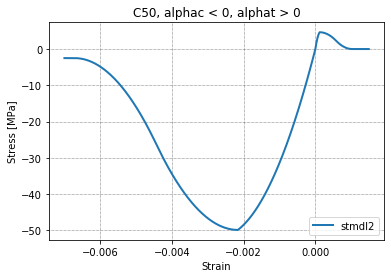

In [12]:
# stmdl2_KR_SS
quad=concr.alpha
alphac=-concr.alpha
alphat=concr.alpha
con1=stmdl2_KR_SS_20201117(ec0,muec1,strnc1,stresc1,et0,muet1,strnt1,pseto,crkso,alphac,alphat)#pset,crks,
con1.plot(title=alpha_plot(alphat,alphac,extra),step_size=0.00001,legend=True,ranges=[-.007,.0015])

In [13]:
# original code
class stmdl2:
    # this is con1 ADAPTIC model
    def __init__(self,ec0,muec1,strnc1,stresc1,et0,muet1,strnt1,pset,crks,quad):#pseto,crkso,
        # This subroutine calculates the stress at a monitoring point for
        # material MODEL(2).

        # Establish the stress depending on the sign of the applied
        # strain relative to the initial plastic set and crack strain
        self.ec0=ec0 # Secant compressive stiffness
        self.muec1=muec1 # Compressive softening stiffness
        self.strnc1=strnc1 # strain at residual compressive strength 
        self.stresc1=stresc1 # residual compressive strength 
        self.et0=et0 # Tensile stiffness
        self.muet1=muet1 # Tensile softening stiffness
        self.strnt1=strnt1 # strain at peak tensile strength ?
        self.pseto=pseto # plastic strain in compression at the start of the step, 
                         # represents the intersection of the unloading branch with the strain axis
        self.crkso=crkso # plastic strain in tension at the start of the step
        self.pset=pseto
        self.crks=crkso
        self.quad=quad
        
    def stress(self, strn):
        self.strn=strn
        if(self.strn<=self.pseto):      # Compressive strain increment
            # NOTE: quad is the relative difference between the initial
            #       compressive tangent modulus and the secant modulus

            self.ec0t=(1+self.quad)*self.ec0 # initial tangent modulus in compression

            if(self.quad>0): # implies quadratic initial compressive response 
                self.strnc0=(self.stresc1-self.muec1*self.strnc1)/(self.ec0-self.muec1)

            # Obtain the stress assuming elastic conditions, and determine
            # the force from the limiting curve
            self.strese=self.ec0t*(self.strn-self.pseto) # elastic stress based on ec0t
            # this gives stress in intial compressive response if quad = 0

            if(self.quad>0 and self.strn>self.strnc0): # initial quadratic response
                # pseto>=strn>strnc0

                #quadratic formulation for stress:
                self.stresl=self.strn*(self.ec0t+(self.ec0-self.ec0t)*self.strn/self.strnc0)
                self.etan=self.ec0t+2*(self.ec0-self.ec0t)*self.strn/self.strnc0

            elif(strn>strnc1): # softening branch

                self.stresl=self.stresc1+self.muec1*(self.strn-self.strnc1)
                self.etan=self.muec1

            else: # residual compressive strength

                self.stresl=self.stresc1
                self.etan=0.0

            # Establish the stress and the plastic set

            if(self.strese>self.stresl):

                self.stres=self.strese
                self.pset=self.pseto
                self.etan=self.ec0t

            else:

                self.stres=self.stresl
                self.pset=self.strn-self.stresl/self.ec0t

            self.crks=self.crkso

        elif(self.et0==0.0 or self.strn<self.crkso+self.pseto):   # Cracked zone
            self.stres=0.0
            self.pset=self.pseto
            self.crks=self.crkso
            self.etan=0

        else:   # Tensile strain increment

            # Obtain the stress assuming elastic conditions, and
            # determine the force from the limiting curve

            self.strese=self.et0*(self.strn-(self.pseto+self.crkso))

            self.stresl=self.muet1*(self.strn-(self.pseto+self.strnt1))+self.et0*self.strnt1

            if(self.stresl>0.0):

                self.etan=self.muet1

            else:
                
                self.stresl=0.0
                self.etan=0.0

            # Establish the stress and the plastic set

            if(self.strese<self.stresl): # initial elastic tensile response

                self.stres=self.strese
                self.etan=self.et0
                self.crks=self.crkso

            else: # tensile softening

                self.stres=self.stresl
                self.crks=self.strn-self.pseto-self.stresl/self.et0

            self.pset=self.pseto
        return self.stres

    def plot(self,title='stmdl2',step_size=0.001,legend=True,ranges=''):
        if ranges=='':ranges=[-np.absolute(self.strnc1),np.absolute(self.strnt1)]
        strain=np.arange(ranges[0],ranges[1],step_size)
        stress=np.array([self.stress(i) for i in strain])
        strain=strain.reshape(len(strain),1)
        stress=stress.reshape(len(stress),1)
        self.df=pd.DataFrame(np.hstack((stress,strain)),columns=['stress','strain'])
        self.np=plotStress(self,self.df,lbl="stmdl2",plotting='True',title=title,legend=legend)
        self.np=np.array(self.np)

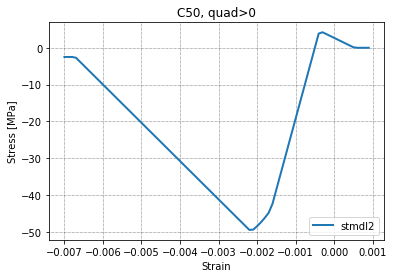

In [14]:
concr = mat.con1('C50', 50, 250, epsilon_t2 = 0.001, fc2_factor = 0.05, characteristic = True,plotting=False,)

strn=-0.0002

ec0=concr.Ec1
muec1=concr.Ec2
et0=concr.Et1
muet1=concr.Et2

strnt1=concr.epsilon_1t
#strnc0=-concr.epsilon_1c
strnc1=-concr.epsilon_2c

stresc1=-concr.fc2
#strnt2=concr.epsilon_2t

pseto=-0.0005#-0.0005
crkso=0#0.0002

quad=concr.alpha
etan=concr.Ec0

#con1=stmdl2(ec0,muec1,strnc1,stresc1,et0,muet1,strnt1,pseto,crkso,quad)#pset,crks,
con1=stmdl2(ec0,muec1,strnc1,stresc1,et0,muet1,strnt1,pseto,crkso,quad)#pset,crks,
con1.stress(strn)
con1.stres
con1.plot(title='C50, quad>0',step_size=0.0001,legend=True,ranges=[-0.007,0.001])#[0,0.001]